In [1]:
import os
import numpy as np 
# -- astropy --
from astropy.io import fits
from desispec.io import read_spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
cata = Cat.GamaLegacy()
gleg = cata.Read()

In [4]:
redshift = gleg['gama-spec']['z_helio']
ngal = len(redshift)

In [5]:
r_mag = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])

In [13]:
f_z_dark = ''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.darksky.seed1.', 
                        str(i_block+1), 'of40blocks.zbest.fits'])
if not os.path.isfile(f_z_dark): 
    continue
zdark_data = fits.open(f_z_dark)[1].data

f_i_dark = ''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.darksky.seed1.', 
                    str(i_block+1), 'of40blocks.index'])
ind_block = np.loadtxt(f_i_dark, unpack=True, usecols=[0], dtype='i')

i_dark = ind_block
zbest_dark = zdark_data['Z']
zwarn_dark = zdark_data['ZWARN']
zerr_dark = zdark_data['ZERR']

f_z_bright = ''.join([UT.dat_dir(), 'redrock/', 'gama_legacy.expSpectra.brightsky.seed1.', 
                    str(i_block+1), 'of40blocks.zbest.fits'])
if not os.path.isfile(f_z_bright): 
    continue 
zbright_data = fits.open(f_z_bright)[1].data

f_i_bright = ''.join([UT.dat_dir(), 'spectra/', 'gama_legacy.expSpectra.brightsky.seed1.', 
                      str(i_block+1), 'of40blocks.index']) 
ind_block = np.loadtxt(f_i_bright, unpack=True, usecols=[0], dtype='i')

i_bright = ind_block
zbest_bright = zbright_data['Z']
zwarn_bright = zbright_data['ZWARN']
zerr_bright = zbright_data['ZERR']

In [14]:
print('%i redshifts' % len(zbest_bright))

994 redshifts


In [15]:
assert np.array_equal(i_dark, i_bright)

In [16]:
z_gama = redshift[i_dark]

In [45]:
mag_cut = (r_mag[i_dark] < 25.0)
print('%f remain after mag cut' % (float(np.sum(mag_cut))/float(len(i_dark))))
print('%i galaxies remaining' % np.sum(mag_cut))

0.901408 remain after mag cut
896 galaxies remaining


In [48]:
print(np.sum(zdark_data['SPECTYPE'][mag_cut] == 'QSO'))
print(np.sum(zbright_data['SPECTYPE'][mag_cut] == 'QSO'))

16
22


(17, 22.0)

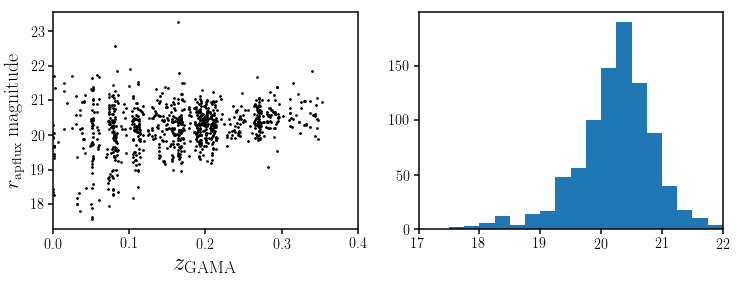

In [49]:
fig = plt.figure(figsize=(12,4))
sub1 = fig.add_subplot(121)
sub1.scatter(z_gama[mag_cut], r_mag[i_dark][mag_cut], s=3, c='k')
sub1.set_xlabel(r'$z_\mathrm{GAMA}$', fontsize=25)
sub1.set_xlim([0., 0.4])
sub1.set_ylabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub2 = fig.add_subplot(122)
_ = sub2.hist(r_mag[i_dark][mag_cut], histtype='stepfilled', range=(17, 22), bins=20)
sub2.set_xlim([17, 22.])

Text(0,0.5,'$z_\\mathrm{redrock}$')

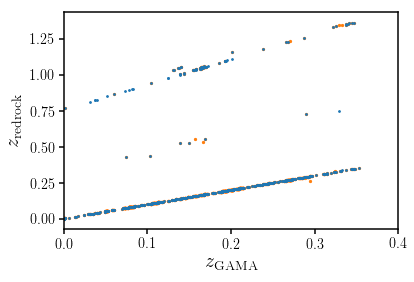

In [50]:
plt.scatter(z_gama[mag_cut], zbest_bright[mag_cut], c='C1', s=5)
plt.scatter(z_gama[mag_cut], zbest_dark[mag_cut], c='C0', s=3)
plt.xlabel(r"$z_\mathrm{GAMA}$", fontsize=20)
plt.xlim([0., 0.4])
plt.ylabel(r"$z_\mathrm{redrock}$", fontsize=20)

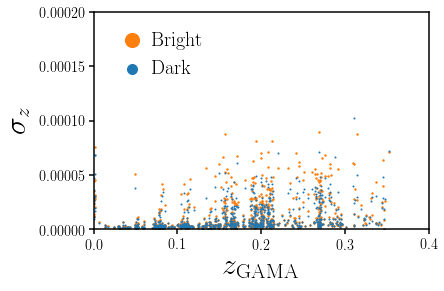

In [20]:
plt.scatter(z_gama[mag_cut], zerr_bright[mag_cut], c='C1', s=2, label='Bright')
plt.scatter(z_gama[mag_cut], zerr_dark[mag_cut], c='C0', s=1, label='Dark')
plt.xlabel(r"$z_\mathrm{GAMA}$", fontsize=30)
plt.xlim([0., 0.4])
plt.ylabel(r"$\sigma_z$", fontsize=30)
plt.ylim([0, 2e-4])
plt.legend(loc='upper left', markerscale=10, handletextpad=0.0, prop={'size': 20})

In [21]:
dz_1pz_dark = (zbest_dark - z_gama)/(1.+z_gama)
dz_1pz_bright = (zbest_bright - z_gama)/(1.+z_gama)

Text(0,0.5,'$\\Delta z / (1+z_\\mathrm{GAMA})$')

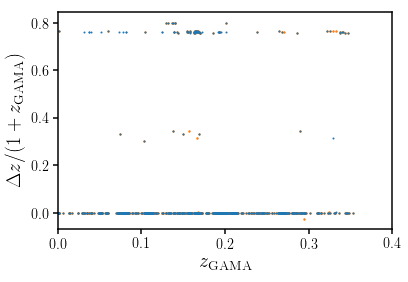

In [22]:
plt.scatter(z_gama[mag_cut], dz_1pz_bright[mag_cut], c='C1', s=2)
plt.scatter(z_gama[mag_cut], dz_1pz_dark[mag_cut], c='C0', s=1)
plt.xlabel(r"$z_\mathrm{GAMA}$", fontsize=20)
plt.xlim([0.,0.4])
plt.ylabel(r"$\Delta z / (1+z_\mathrm{GAMA})$", fontsize=20)

Text(0,0.5,'$\\Delta z / (1+z_\\mathrm{GAMA})$')

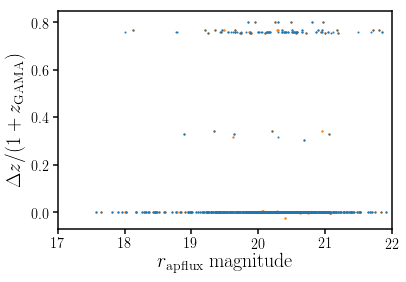

In [23]:
plt.scatter(r_mag[i_dark][mag_cut], dz_1pz_bright[mag_cut], c='C1', s=2)
plt.scatter(r_mag[i_dark][mag_cut], dz_1pz_dark[mag_cut], c='C0', s=1)
plt.xlabel(r"$r_\mathrm{apflux}$ magnitude", fontsize=20)
plt.xlim([17., 22.])
plt.ylabel(r"$\Delta z / (1+z_\mathrm{GAMA})$", fontsize=20)

(-0.005, 0.003)

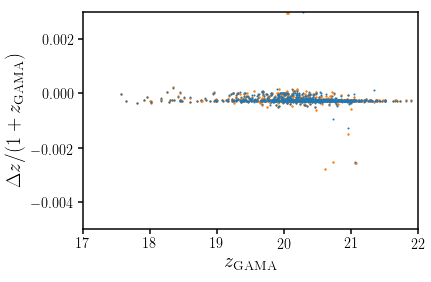

In [86]:
plt.scatter(r_mag[i_dark][mag_cut], dz_1pz_bright[mag_cut], c='C1', s=2)
plt.scatter(r_mag[i_dark][mag_cut], dz_1pz_dark[mag_cut], c='C0', s=1)
plt.xlabel(r"$z_\mathrm{GAMA}$", fontsize=20)
plt.xlim([17., 22.])
plt.ylabel(r"$\Delta z / (1+z_\mathrm{GAMA})$", fontsize=20)
plt.ylim([-0.005, 0.003])

In [93]:
def gethist(var, ztrue, zbest, range=None):
    """Generate the histogram (and Poisson uncertainty) for various 
    sample cuts.  See zstats() for details.

    """
    dz = zbest - ztrue
    dz_1pz = np.abs(dz/(1.+ztrue))
    s1 = (dz_1pz < 0.003)
    
    h0, bins = np.histogram(var, bins=20, range=range)
    hv, _ = np.histogram(var, bins=bins, weights=var)
    h1, _ = np.histogram(var[s1], bins=bins)

    good = h0 > 2
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    vv = hv / h0
    
    def _eff(k, n):
        eff = k.astype("float") / (n.astype('float') + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n.astype('float') + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)

    return vv, e1, ee1

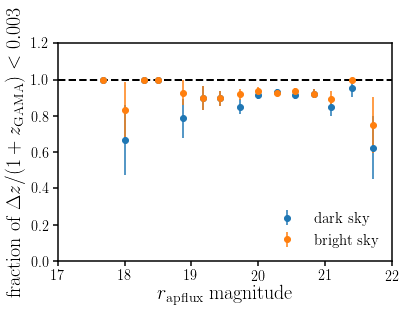

In [94]:
mm_dark, e1_dark, ee1_dark = gethist(r_mag[i_dark][mag_cut], z_gama[mag_cut], zbest_dark[mag_cut])
mm_bright, e1_bright, ee1_bright = gethist(r_mag[i_dark][mag_cut], z_gama[mag_cut], zbest_bright[mag_cut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([17., 22.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, c='C1', fmt='o', label="bright sky")
sub.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub.set_xlim([17., 22.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})

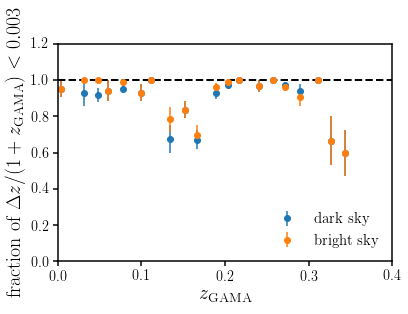

In [95]:
mm_dark, e1_dark, ee1_dark = gethist(redshift[i_dark][mag_cut], z_gama[mag_cut], zbest_dark[mag_cut])
mm_bright, e1_bright, ee1_bright = gethist(redshift[i_dark][mag_cut], z_gama[mag_cut], zbest_bright[mag_cut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 0.5], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, c='C1', fmt='o', label="bright sky")
sub.set_xlabel(r'$z_\mathrm{GAMA}$', fontsize=20)
sub.set_xlim([0.0, 0.4])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})

In [96]:
gama_ha = gleg['gama-spec']['ha']
legacy_g = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
legacy_r = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
legacy_gr = legacy_g - legacy_r

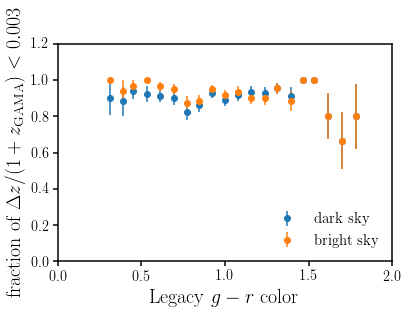

In [97]:
mm_dark, e1_dark, ee1_dark = gethist(legacy_gr[i_dark][mag_cut], z_gama[mag_cut], zbest_dark[mag_cut])
mm_bright, e1_bright, ee1_bright = gethist(legacy_gr[i_dark][mag_cut], z_gama[mag_cut], zbest_bright[mag_cut])

fig = plt.figure()
sub = fig.add_subplot(111)
#sub.plot([0., 0.5], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, c='C1', fmt='o', label="bright sky")
sub.set_xlabel(r'Legacy $g-r$ color', fontsize=20)
sub.set_xlim([0., 2.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})

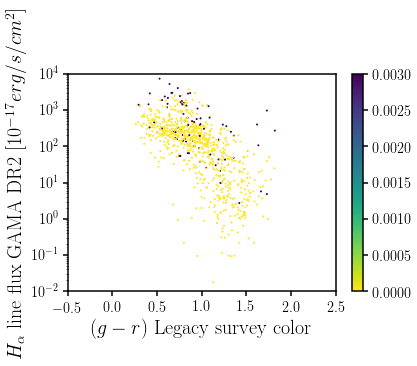

In [92]:
fig = plt.figure()
sub = fig.add_subplot(111)
cc = sub.scatter(legacy_gr[i_dark][mag_cut], gama_ha[i_dark][mag_cut], s=1, c=dz_1pz_dark[mag_cut], 
                 cmap='viridis_r', vmin=0, vmax=0.003)
sub.set_xlabel('$(g-r)$ Legacy survey color', fontsize=20)
sub.set_xlim([-0.5, 2.5])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([1e-2, 1e4])
sub.set_yscale('log')
fig.colorbar(cc)

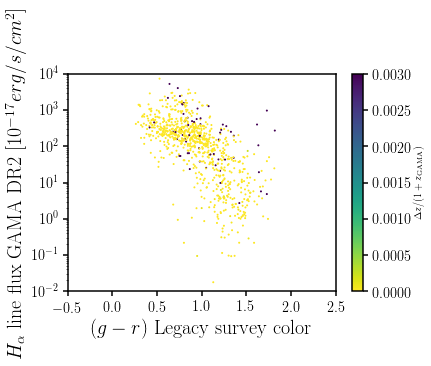

In [29]:
fig = plt.figure()
sub = fig.add_subplot(111)
cc = sub.scatter(legacy_gr[i_dark][mag_cut], gama_ha[i_dark][mag_cut], s=1, c=dz_1pz_bright[mag_cut], 
                 cmap='viridis_r', vmin=0, vmax=0.003)
sub.set_xlabel('$(g-r)$ Legacy survey color', fontsize=20)
sub.set_xlim([-0.5, 2.5])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([1e-2, 1e4])
sub.set_yscale('log')
fig.colorbar(cc, label=r'$\Delta z/(1+z_\mathrm{GAMA})$')

In [38]:
weird = (dz_1pz_bright < dz_1pz_dark) & mag_cut
notweird = (dz_1pz_bright >= dz_1pz_dark) & mag_cut

In [39]:
print('%i weird' % np.sum(weird))
print('%i not weird' % np.sum(notweird))

298 weird
598 not weird


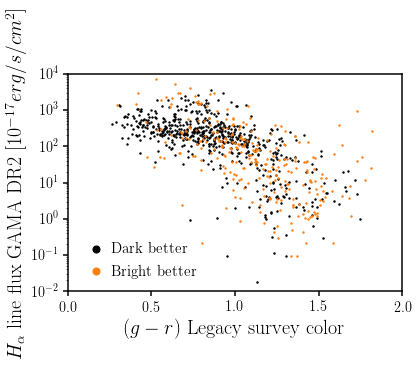

In [44]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.scatter(legacy_gr[i_dark][notweird], gama_ha[i_dark][notweird], s=2, c='k', label='Dark better')
sub.scatter(legacy_gr[i_dark][weird], gama_ha[i_dark][weird], s=2, c='C1', label='Bright better')
sub.set_xlabel('$(g-r)$ Legacy survey color', fontsize=20)
sub.set_xlim([0, 2.])
sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_ylim([1e-2, 1e4])
sub.set_yscale('log')
sub.legend(loc='lower left', markerscale=5, handletextpad=0., prop={'size': 15})